# A Notebook for Calculating Weight by Target Weight Distribution

In [1]:
import shutil
import h5py as h5
import numpy as np
import mplhep as hep
import matplotlib.pyplot as plt
plt.style.use(hep.style.CMS)

import awkward as ak

import vector
vector.register_awkward()
vector.register_numba()

## load dataset and get the target weight distribution

### simple load dataset

In [2]:
def awk2npy(arr):
    return np.array(arr)[..., np.newaxis]

In [3]:
result_path = "/hhh-vol/data/delphes/v2/merged_training_all_w_weights.h5"

In [4]:
f = h5.File(result_path, 'r')

In [5]:
f['TARGETS']['h1'].keys()

<KeysViewHDF5 ['WEIGHT', 'b1', 'b2', 'mask', 'mh', 'pt']>

In [6]:
for i in range(1, 4):
    exec(f"rh{i}_mass = awk2npy(f[\'TARGETS\'][\'h{i}\'][\'mh\'])")
    exec(f"bh{i}_mass = awk2npy(f[\'TARGETS\'][\'bh{i}\'][\'mh\'])")

In [7]:
for i in range(1, 4):
    exec(f"rh{i}_mask = awk2npy(f[\'TARGETS\'][\'h{i}\'][\'mask\'])")
    exec(f"bh{i}_mask = awk2npy(f[\'TARGETS\'][\'bh{i}\'][\'mask\'])")

In [8]:
rh_mass_list = []
for i in range(1, 4):
    exec(f"rh_mass_list.append(rh{i}_mass)")
rh_mass = np.concatenate(rh_mass_list, axis=1)

In [9]:
rh_mask_list = []
for i in range(1, 4):
    exec(f"rh_mask_list.append(rh{i}_mask)")
rh_mask = np.concatenate(rh_mask_list, axis=1)

In [10]:
bh_mass_list = []
for i in range(1, 4):
    exec(f"bh_mass_list.append(bh{i}_mass)")
bh_mass = np.concatenate(bh_mass_list, axis=1)

In [11]:
bh_mask_list = []
for i in range(1, 4):
    exec(f"bh_mask_list.append(bh{i}_mask)")
bh_mask = np.concatenate(bh_mask_list, axis=1)

In [12]:
j_pt = np.array(f["INPUTS"]["Jets"]["pt"])
j_eta = np.array(f["INPUTS"]["Jets"]["eta"])
j_phi = np.array(f["INPUTS"]["Jets"]["phi"])
j_mass = np.array(f["INPUTS"]["Jets"]["mass"])

In [13]:
js = ak.zip(
        {
            "pt": j_pt,
            "eta": j_eta,
            "phi": j_phi,
            "mass": j_mass,
        },
        with_name="Momentum4D",
    )

In [14]:
for i in range(1, 4):
    exec(f"rh{i}_b1s = awk2npy(f[\"TARGETS\"][\"h{i}\"][\"b1\"])")
    exec(f"rh{i}_b2s = awk2npy(f[\"TARGETS\"][\"h{i}\"][\"b2\"])")

In [15]:
rh_b1_list = []
for i in range(1, 4):
    exec(f"rh_b1_list.append(rh{i}_b1s)")
rh_b1 = np.concatenate(rh_b1_list, axis=1)

In [16]:
rh_b2_list = []
for i in range(1, 4):
    exec(f"rh_b2_list.append(rh{i}_b2s)")
rh_b2 = np.concatenate(rh_b2_list, axis=1)

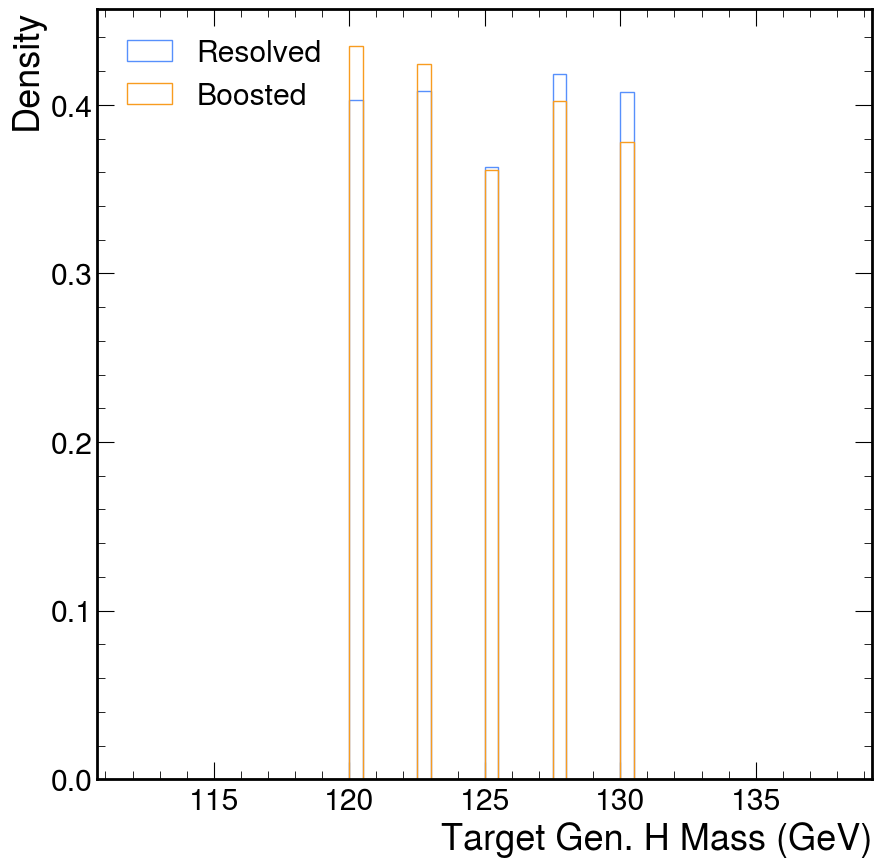

In [17]:
plt.hist(rh_mass[rh_mask], bins=np.arange(112, 138.5, 0.5), density=True, histtype='step', label='Resolved')
plt.hist(bh_mass[bh_mask], bins=np.arange(112, 138.5, 0.5), density=True, histtype='step', label='Boosted')

# plt.title("Reconstructed Resolved Mass Distribution")
plt.legend()
plt.xlabel('Target Gen. H Mass (GeV)')
plt.ylabel('Density')
plt.savefig(fname='/hhh-vol/plots/target_gen_mass_dist.pdf', format='pdf')

### calculate resolved reco mass

In [18]:
b1s = js[np.arange(rh_b1.shape[0])[:, None], rh_b1]
b2s = js[np.arange(rh_b2.shape[0])[:, None], rh_b2]

In [19]:
rH_reco = (b1s+b2s)[rh_mask]
rH_reco_mass = rH_reco.M

### calculate boosted reco mass

In [20]:
fj_pt = np.array(f["INPUTS"]["BoostedJets"]["fj_pt"])
fj_eta = np.array(f["INPUTS"]["BoostedJets"]["fj_eta"])
fj_phi = np.array(f["INPUTS"]["BoostedJets"]["fj_phi"])
fj_mass = np.array(f["INPUTS"]["BoostedJets"]["fj_mass"])

In [21]:
fjs = ak.zip(
        {
            "pt": fj_pt,
            "eta": fj_eta,
            "phi": fj_phi,
            "mass": fj_mass,
        },
        with_name="Momentum4D",
    )

In [22]:
for i in range(1, 4):
    exec(f"bh{i}_bbs = awk2npy(f[\"TARGETS\"][\"bh{i}\"][\"bb\"])")

In [23]:
bh_bb_list = []
for i in range(1, 4):
    exec(f"bh_bb_list.append(bh{i}_bbs)")
bh_bb = np.concatenate(bh_bb_list, axis=1)

In [24]:
bb = fjs[np.arange(len(fjs))[:, None], bh_bb]
bH_reco = bb[bh_mask]
bH_reco_mass = bH_reco.M

### plot the Higgs reco mass

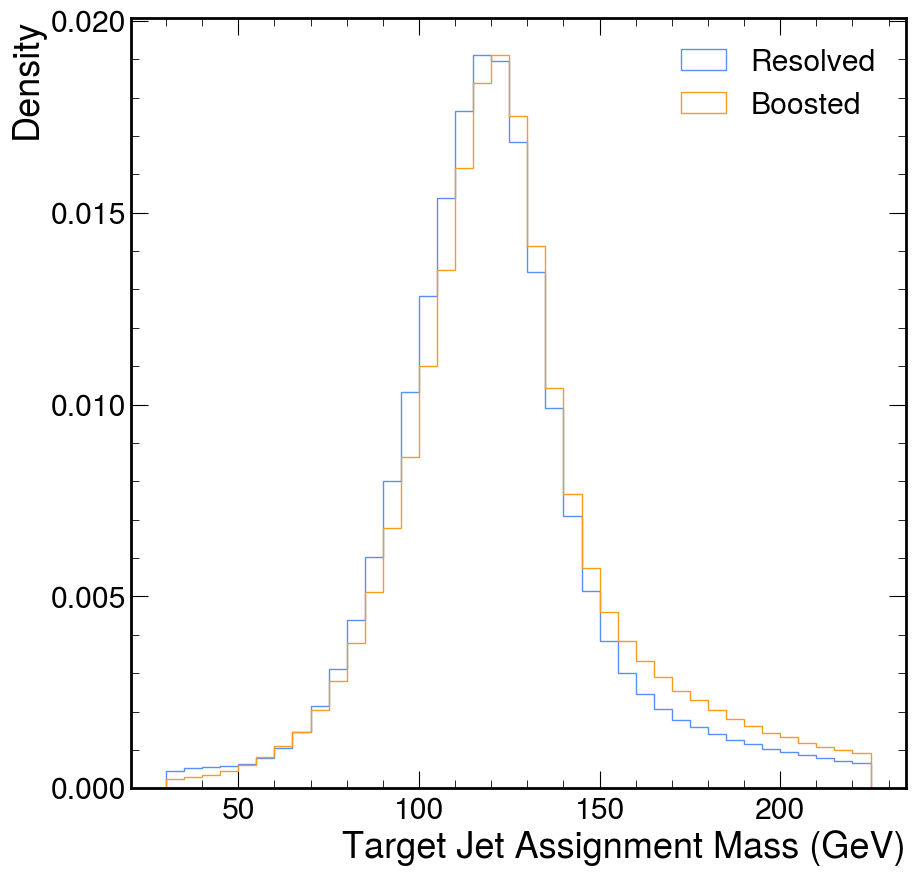

In [39]:
plt.hist(rH_reco_mass, bins=np.arange(30, 230, 5), density=True, histtype='step', label='Resolved')
plt.hist(bH_reco_mass, bins=np.arange(30, 230, 5), density=True, histtype='step', label='Boosted')

# plt.title("Reconstructed Resolved Mass Distribution")
plt.legend()
plt.xlabel('Target Jet Assignment Mass (GeV)')
plt.ylabel('Density')
plt.yticks(np.arange(0, 0.02+0.005, 0.005))
plt.savefig(fname='/hhh-vol/plots/target_reco_mass_dist.pdf', format='pdf')

## Get the weight of each target

### get the weights of the resolved targets

In [26]:
for i in range(1, 4):
    exec(f"rh{i}_weight = awk2npy(f[\'TARGETS\'][\'h{i}\'][\'WEIGHT\'])")
    exec(f"bh{i}_weight = awk2npy(f[\'TARGETS\'][\'bh{i}\'][\'WEIGHT\'])")

In [27]:
rh_weight_list = []
for i in range(1, 4):
    exec(f"rh_weight_list.append(rh{i}_weight)")
rh_weight = np.concatenate(rh_weight_list, axis=1)
rh_weight = rh_weight[rh_mask]

In [28]:
bh_weight_list = []
for i in range(1, 4):
    exec(f"bh_weight_list.append(bh{i}_weight)")
bh_weight = np.concatenate(bh_weight_list, axis=1)
bh_weight = bh_weight[bh_mask]

## Plot weights

(70.0, 180.0)

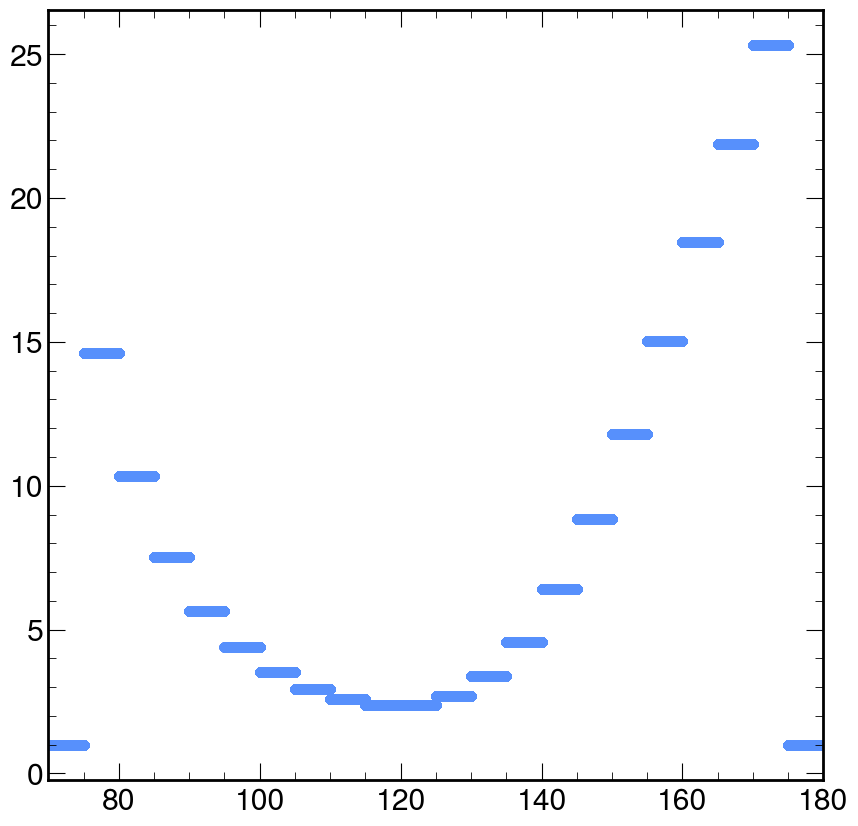

In [29]:
plt.scatter(x=rH_reco_mass, y=rh_weight)
plt.xlim([70, 180])

(70.0, 180.0)

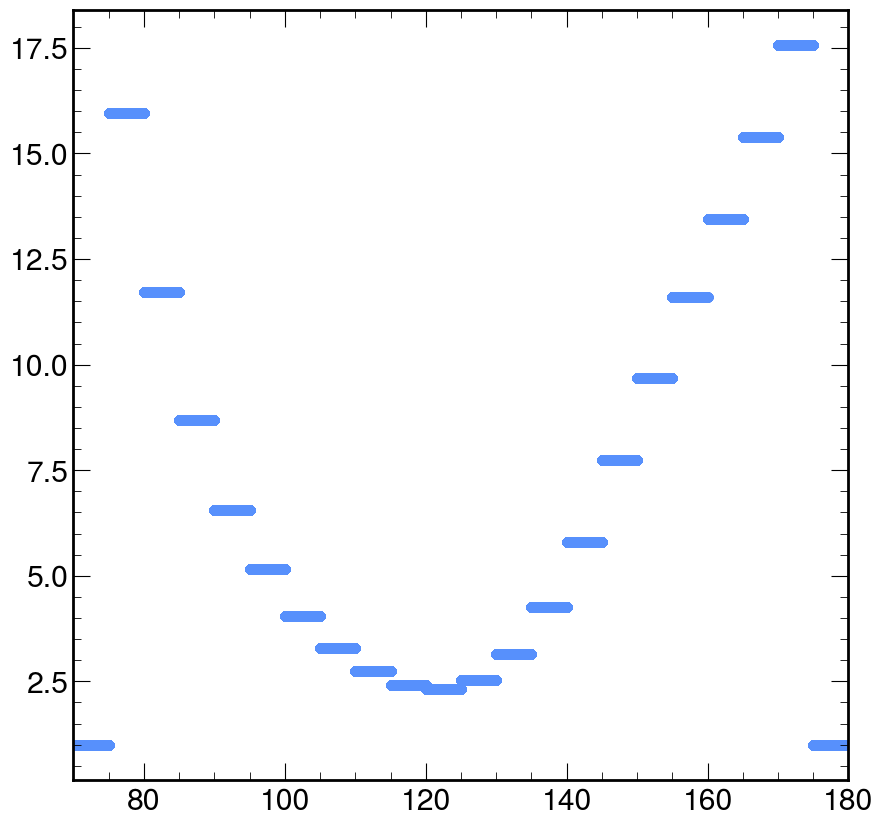

In [30]:
plt.scatter(x=bH_reco_mass, y=bh_weight)
plt.xlim([70, 180])

### A prettier way to plot weights 

### calcualte the weight of each mass bin

In [31]:
# calculate mass density
bins = np.arange(75, 180, 5)
rH_mass_density, bins = np.histogram(rH_reco_mass, bins=bins, density=True)
bH_mass_density, bins = np.histogram(bH_reco_mass, bins=bins, density=True)

# calculate flat density
flat_density = 1/len(bins[:-1])

# calculate weight per bin
# mass density x weight = flat density
rH_weight = flat_density/rH_mass_density
bH_weight = flat_density/bH_mass_density

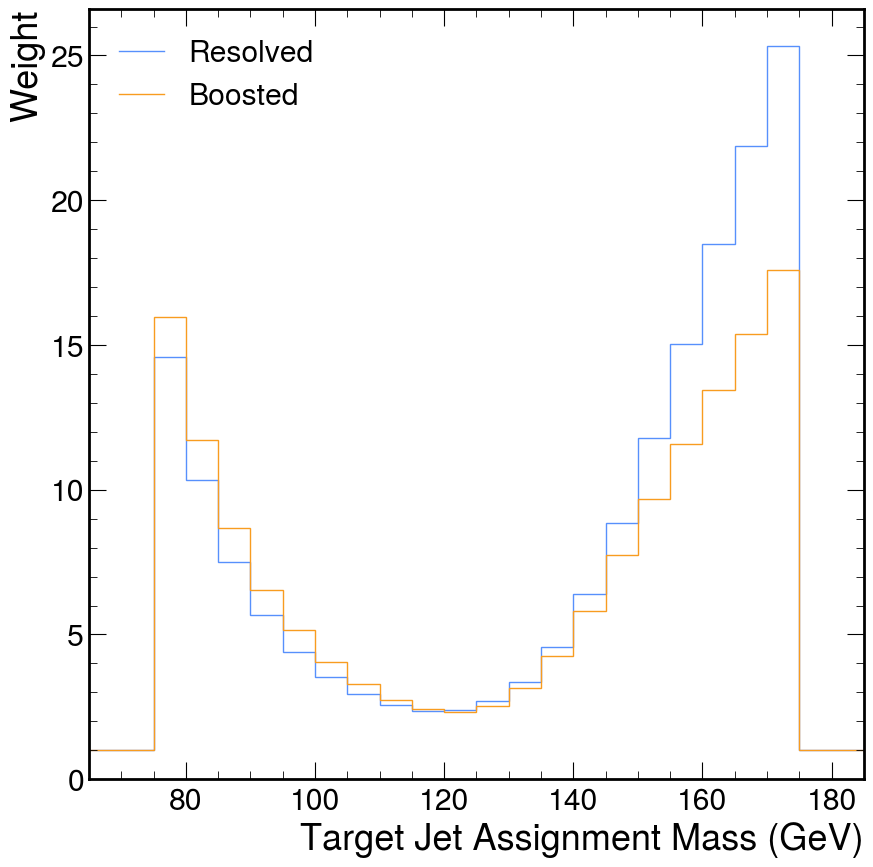

In [32]:
plt.stairs(edges=np.arange(50, 205, 5), values=[*np.ones(5), *rH_weight, *np.ones(5)], label='Resolved')
plt.stairs(edges=np.arange(50, 205, 5), values=[*np.ones(5), *bH_weight, *np.ones(5)], label='Boosted')

plt.xlim([65,185])
plt.legend()
plt.xlabel('Target Jet Assignment Mass (GeV)')
plt.ylabel('Weight')

plt.savefig(fname='/hhh-vol/plots/target_weight_dist.pdf', format='pdf')

## Validate weight

In [33]:
# caluclate target reco mass
resolved_target_mass = (b1s+b2s).M
boosted_target_mass = bb.M

In [34]:
# find which mass bin the target is
resolved_mass_bin_idx = np.digitize(resolved_target_mass, bins)
boosted_mass_bin_idx = np.digitize(boosted_target_mass, bins)

In [35]:
resolved_target_weight = ak.ones_like(resolved_target_mass)
resolved_target_weight = np.array(resolved_target_weight)

In [36]:
boosted_target_weight = ak.ones_like(boosted_target_mass)
boosted_target_weight = np.array(boosted_target_weight)

In [37]:
# first and last bin weight is one
for i in range(1, len(bins)):
    resolved_in_bin_i = resolved_mass_bin_idx == i
    boosted_in_bin_i = boosted_mass_bin_idx == i
    
    resolved_target_weight[resolved_in_bin_i] = rH_weight[i-1]
    boosted_target_weight[boosted_in_bin_i] = bH_weight[i-1]

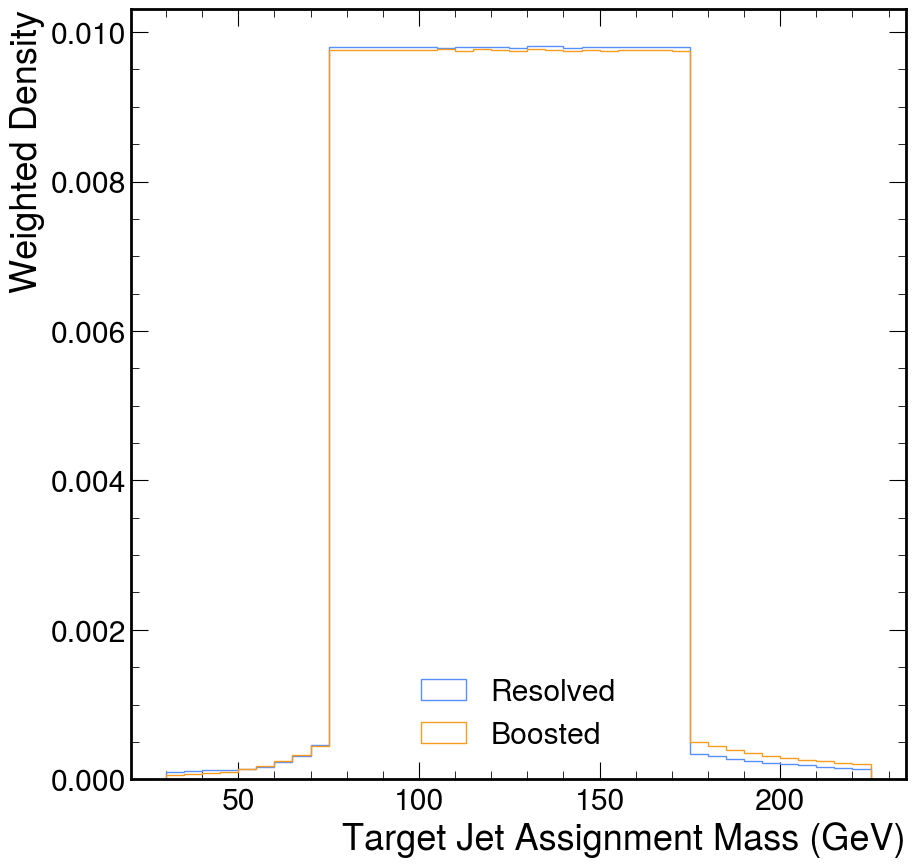

In [38]:
plt.hist(resolved_target_mass[rh_mask], bins=np.arange(30, 230, 5), histtype='step', weights=resolved_target_weight[rh_mask], density=True, label='Resolved')
plt.hist(boosted_target_mass[bh_mask], bins=np.arange(30, 230, 5), histtype='step', weights=boosted_target_weight[bh_mask], density=True, label='Boosted')
plt.legend()
plt.xlabel('Target Jet Assignment Mass (GeV)')
plt.ylabel('Weighted Density')
plt.savefig(fname='/hhh-vol/plots/target_weighted_reco_mass_dist.pdf', format='pdf')